# Neural Network für Klassifizierung von arabischen Zahlen

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import gzip
import struct
import os

from mlxtend.data import loadlocal_mnist

In [2]:
dataset_folder = os.path.abspath("../emnist_dataset")
print(dataset_folder)

/home/isaac/Documents/master/computer_and_robot_vision/CRV_Postleitzahlerkennung/emnist_dataset


In [3]:
class CrvModel:
    def __init__(self, dataset_folder):
        
        # Constants and Paths for Networks
        self.dataset_path = dataset_folder
        self.emnist_classes = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        self.num_emnist_classes = len(self.emnist_classes)
        self.mnist_classes = "0123456789"
        self.num_mnist_classes = len(self.mnist_classes)
        self.emnist_letter_classes = "-abcdefghijklmnopqrstuvwxyz"
        self.num_emnist_letter_classes = len(self.emnist_letter_classes)
        self.german_digits_classes = "0123456789"
        self.num_german_digits_classes = len(self.german_digits_classes)
        
        # Constants for training and paths to save models
        self.batch_size = 1024
        self.epochs = 200
        self.emnist_save_path = "./emnist_byclass.h5"
        self.emnist_letter_save_path = "./emnist_letter.h5"
        self.mnist_save_path = "./mnist.h5"
        self.german_digit_network_save_path = "./german_digits_network.h5"

        # Read in or download raw data for models
        self.raw_emnist_train_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-train-images-idx3-ubyte.gz'))
        self.raw_emnist_train_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-train-labels-idx1-ubyte.gz'))
        self.raw_emnist_test_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-test-images-idx3-ubyte.gz'))
        self.raw_emnist_test_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-test-labels-idx1-ubyte.gz'))

        self.raw_emnist_letter_train_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-train-images-idx3-ubyte.gz'))
        self.raw_emnist_letter_train_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-train-labels-idx1-ubyte.gz'))
        self.raw_emnist_letter_test_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-test-images-idx3-ubyte.gz'))
        self.raw_emnist_letter_test_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-test-labels-idx1-ubyte.gz'))

        (self.raw_mnist_train_img, self.raw_mnist_train_labels), (self.raw_mnist_test_img, self.raw_mnist_test_labels) = tf.keras.datasets.mnist.load_data()

        self.raw_german_digit_train_img, self.raw_german_digit_train_labels = self.load_german_digits('german_train.data', 'german_train.labels')
        self.raw_german_digit_test_img, self.raw_german_digit_test_labels = self.load_german_digits('german_test.data', 'german_test.labels')

        
        # Preprocess data
        self.emnist_train_img = self.preprocess_data(self.raw_emnist_train_img)
        self.emnist_test_img = self.preprocess_data(self.raw_emnist_test_img)
        self.emnist_train_labels = tf.keras.utils.to_categorical(self.raw_emnist_train_labels)
        self.emnist_test_labels = tf.keras.utils.to_categorical(self.raw_emnist_test_labels)
        
        self.mnist_train_img = self.preprocess_data(self.raw_mnist_train_img)
        self.mnist_test_img = self.preprocess_data(self.raw_mnist_test_img)
        self.mnist_train_labels = tf.keras.utils.to_categorical(self.raw_mnist_train_labels)
        self.mnist_test_labels = tf.keras.utils.to_categorical(self.raw_mnist_test_labels)

        self.emnist_letter_train_img = self.preprocess_data(self.raw_emnist_letter_train_img)
        self.emnist_letter_test_img = self.preprocess_data(self.raw_emnist_letter_test_img)
        self.emnist_letter_train_labels = tf.keras.utils.to_categorical(self.raw_emnist_letter_train_labels)
        self.emnist_letter_test_labels = tf.keras.utils.to_categorical(self.raw_emnist_letter_test_labels)

        self.german_digit_train_img = self.preprocess_data(self.raw_german_digit_train_img)
        self.german_digit_test_img = self.preprocess_data(self.raw_german_digit_test_img)
        self.german_digit_train_labels = tf.keras.utils.to_categorical(self.raw_german_digit_train_labels)
        self.german_digit_test_labels = tf.keras.utils.to_categorical(self.raw_german_digit_test_labels)

        # Earlystopping Callback
        self.early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                    min_delta=0.002,
                                                                    patience=10,
                                                                    verbose = 1,
                                                                    restore_best_weights=True)
                                                                    
        self.german_digits_save_weights_callback = tf.keras.callbacks.ModelCheckpoint(self.german_digit_network_save_path,
                                                        monitor="val_loss",
                                                        verbose=1,
                                                        save_best_only=True,
                                                        save_weights_only=True
                                                    )


        # Setup network architecture
        self.emnist_cnn = self.setup_network(self.num_emnist_classes)
        self.emnist_letter_cnn = self.setup_network(self.num_emnist_letter_classes)
        self.mnist_cnn = self.setup_network(self.num_mnist_classes)
        self.german_digits_network = self.setup_network(self.num_german_digits_classes)


    
    # Function Definitions
    def load_german_digits(self, img_path, labels_path):
        train_img, train_labels = loadlocal_mnist(
            images_path=img_path, 
            labels_path=labels_path)
        train_img = train_img.reshape(train_img.shape[0], 28, 28)
        return train_img, train_labels
        
    def read_local_data(self, path):
        print("Lese Datenset '%s' ein" %path)
        with gzip.open(path, "rb") as f:
            z, dtype, dim = struct.unpack(">HBB", f.read(4))
            print("Dimensions:", dim)
            shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dim))
            print("Shape:", shape)
            print("***********************************************")
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
        
    def show_random_image(self, data_imgs, classes, data_labels):
        i = random.randint(0, data_imgs.shape[0])
        fig, ax = plt.subplots()
        ax.clear()
        ax.imshow(data_imgs[i].T, cmap="gray")
        title = "label = %d = %s" %(data_labels[i], classes[data_labels[i]])
        ax.set_title(title, fontsize=20)
        plt.show()
        
    def preprocess_data(self, raw_data):
        normalized_data = raw_data.astype("float32")/255
        reshaped_data = normalized_data.reshape(normalized_data.shape[0], 28, 28, 1)
        return reshaped_data

    def setup_network(self, num_classes):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Conv2D(128, kernel_size = 4, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.4))
        model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
        return model
        

## Model initialisieren

In [4]:
model = CrvModel(dataset_folder)

Lese Datenset '/home/isaac/Documents/master/computer_and_robot_vision/CRV_Postleitzahlerkennung/emnist_dataset/emnist-byclass-train-images-idx3-ubyte.gz' ein
Dimensions: 3
Shape: (697932, 28, 28)
***********************************************
Lese Datenset '/home/isaac/Documents/master/computer_and_robot_vision/CRV_Postleitzahlerkennung/emnist_dataset/emnist-byclass-train-labels-idx1-ubyte.gz' ein
Dimensions: 1
Shape: (697932,)
***********************************************
Lese Datenset '/home/isaac/Documents/master/computer_and_robot_vision/CRV_Postleitzahlerkennung/emnist_dataset/emnist-byclass-test-images-idx3-ubyte.gz' ein
Dimensions: 3
Shape: (116323, 28, 28)
***********************************************
Lese Datenset '/home/isaac/Documents/master/computer_and_robot_vision/CRV_Postleitzahlerkennung/emnist_dataset/emnist-byclass-test-labels-idx1-ubyte.gz' ein
Dimensions: 1
Shape: (116323,)
***********************************************
Lese Datenset '/home/isaac/Documents/mas

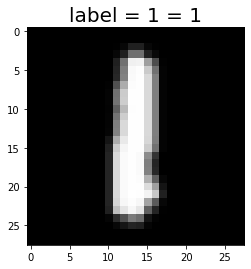

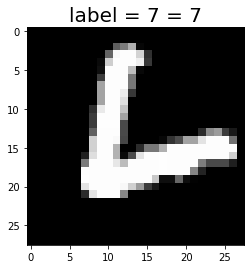

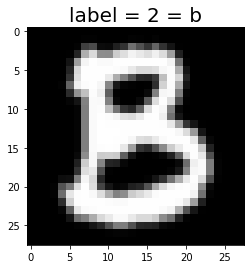

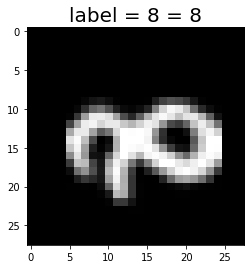

In [5]:
model.show_random_image(model.raw_emnist_train_img, model.emnist_classes, model.raw_emnist_train_labels)
model.show_random_image(model.raw_mnist_train_img, model.mnist_classes, model.raw_mnist_train_labels)
model.show_random_image(model.raw_emnist_letter_train_img, model.emnist_letter_classes, model.raw_emnist_letter_train_labels)
model.show_random_image(model.raw_german_digit_train_img, model.german_digits_classes, model.raw_german_digit_train_labels)

In [6]:
print("-----------------------------------------------------------------------------")
print("Full Emnist Neural Network")

model.emnist_cnn.summary()
model.emnist_cnn.compile(loss = "categorical_crossentropy",
                         optimizer = "adam",
                         metrics = ["accuracy"],
                         callbacks = [model.early_stopping_callback])

print("-----------------------------------------------------------------------------")
print("Emnist Letter Neural Network")
model.emnist_letter_cnn.summary()
model.emnist_letter_cnn.compile(loss = "categorical_crossentropy",
                         optimizer = "adam",
                         metrics = ["accuracy"],
                         callbacks = [model.early_stopping_callback])

print("-----------------------------------------------------------------------------")
print("Mnist Neural Network")
model.mnist_cnn.summary()
model.mnist_cnn.compile(loss = "categorical_crossentropy", 
                        optimizer = "adam",
                        metrics = ["accuracy"])

print("-----------------------------------------------------------------------------")
print("German Digits Network")
model.german_digits_network.summary()
model.german_digits_network.compile(loss = "categorical_crossentropy", 
                        optimizer = "adam",
                        metrics = ["accuracy"])

-----------------------------------------------------------------------------
Full Emnist Neural Network
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________

In [7]:
print("*******************************************************************")
print("Train Emnist Model")
print("*******************************************************************")

model.emnist_trained = model.emnist_cnn.fit(model.emnist_train_img,
              model.emnist_train_labels,
              batch_size = model.batch_size,
              epochs = model.epochs,
              verbose = 1,
              validation_data = (model.emnist_test_img, model.emnist_test_labels),
               callbacks = [model.early_stopping_callback])

model.emnist_cnn.save(model.emnist_save_path)

print("*******************************************************************")
print("Train Emnist Letter Model")
print("*******************************************************************")

model.emnist_letter_trained = model.emnist_letter_cnn.fit(model.emnist_letter_train_img,
              model.emnist_letter_train_labels,
              batch_size = model.batch_size,
              epochs = model.epochs,
              verbose = 1,
              validation_data = (model.emnist_letter_test_img, model.emnist_letter_test_labels),
              callbacks = [model.early_stopping_callback])

model.emnist_letter_cnn.save(model.emnist_letter_save_path)


print("*******************************************************************")
print("Train Mnist Letter Model")
print("*******************************************************************")

model.mnist_trained = model.mnist_cnn.fit(model.mnist_train_img,
                                    model.mnist_train_labels,
                                    batch_size = model.batch_size,
                                    epochs = model.epochs,
                                    verbose = 1,
                                    validation_data = (model.mnist_test_img, model.mnist_test_labels),
                                    callbacks = [model.early_stopping_callback])

model.mnist_cnn.save(model.mnist_save_path)


print("*******************************************************************")
print("Train German Digits Model")
print("*******************************************************************")

model.german_digits_trained = model.german_digits_network.fit(model.german_digit_train_img,
                                    model.german_digit_train_labels,
                                    batch_size = model.batch_size,
                                    epochs = model.epochs,
                                    verbose = 1,
                                    validation_data = (model.german_digit_test_img, model.german_digit_test_labels),
                                    callbacks = [model.german_digits_save_weights_callback]
                                )

model.german_digits_network.load_weights(model.german_digit_network_save_path)

=============================] - 0s 65us/sample - loss: 6.0284e-04 - accuracy: 0.9999 - val_loss: 0.1612 - val_accuracy: 0.9726
Epoch 134/200
7168/7291 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990
Epoch 00134: val_loss did not improve from 0.14190
7291/7291 [==============================] - 0s 64us/sample - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.1622 - val_accuracy: 0.9681
Epoch 135/200
7168/7291 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9994
Epoch 00135: val_loss did not improve from 0.14190
7291/7291 [==============================] - 0s 64us/sample - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.1476 - val_accuracy: 0.9686
Epoch 136/200
7168/7291 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9999
Epoch 00136: val_loss did not improve from 0.14190
7291/7291 [==============================] - 0s 64us/sample - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.1498 - val_accuracy: 0.9706
Epoch 13

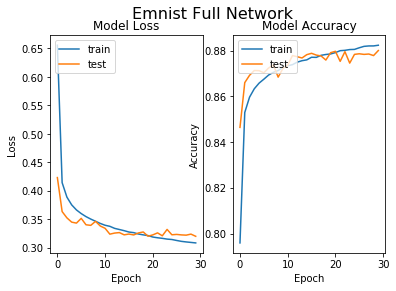

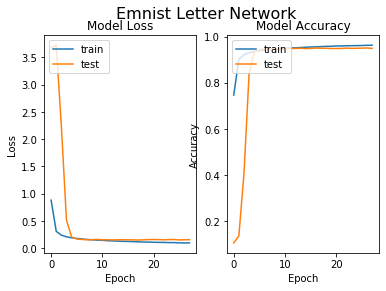

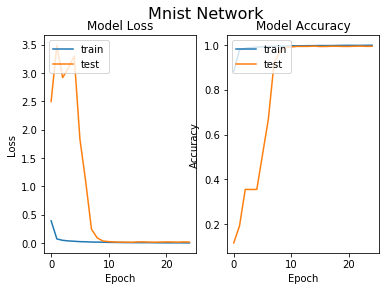

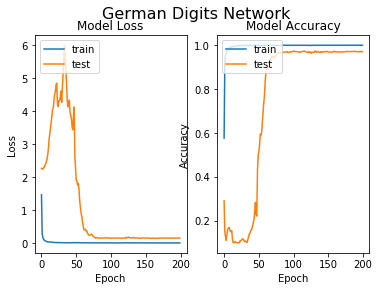

In [8]:
def visualize_result(model_name, model_history):
    plt.figure()
    plt.suptitle(model_name, fontsize=16)
    plt.subplot(1, 2, 1)
    plt.plot(model_history['loss'])
    plt.plot(model_history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(model_history['accuracy'])
    plt.plot(model_history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

visualize_result("Emnist Full Network", model.emnist_trained.history)
visualize_result("Emnist Letter Network", model.emnist_letter_trained.history)
visualize_result("Mnist Network", model.mnist_trained.history)
visualize_result("German Digits Network", model.german_digits_trained.history)

In [9]:
emnist_results = model.emnist_cnn.evaluate(model.emnist_test_img, model.emnist_test_labels, verbose=0)
emnist_letter_results = model.emnist_letter_cnn.evaluate(model.emnist_letter_test_img, model.emnist_letter_test_labels, verbose=0)
mnist_results = model.mnist_cnn.evaluate(model.mnist_test_img, model.mnist_test_labels, verbose=0)
german_digits_results = model.german_digits_network.evaluate(model.german_digit_test_img, model.german_digit_test_labels, verbose=0)

print('Emnist Loss: %.2f%%, Accuracy: %.2f%%' % (emnist_results[0]*100, emnist_results[1]*100))
print('Emnist Letter Loss: %.2f%%, Accuracy: %.2f%%' % (emnist_letter_results[0]*100, emnist_letter_results[1]*100))
print('Mnist Loss: %.2f%%, Accuracy: %.2f%%' % (mnist_results[0]*100, mnist_results[1]*100))
print('German Digits Loss: %.2f%%, Accuracy: %.2f%%' % (german_digits_results[0]*100, german_digits_results[1]*100))

Emnist Loss: 32.03%, Accuracy: 87.91%
Emnist Letter Loss: 15.13%, Accuracy: 94.91%
Mnist Loss: 1.71%, Accuracy: 99.46%
German Digits Loss: 13.74%, Accuracy: 97.21%
